[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ELTE-DSED/Intro-Data-Security/blob/main/module_03_data_poisoning/Lab_3b_Data_Poisoning_Backdoor_Attacks.ipynb)

# **Lab 3b: Data Poisoning Attacks (Backdoor & Trigger Injection)**

**Course:** Introduction to Data Security Pr.  
**Module 3:** Integrity Attacks - Data Poisoning  
**Estimated Time:** 120 minutes

---

## **Learning Objectives**

By the end of this lab, you will be able to:

1. **Design** and inject backdoor triggers into training data
2. **Implement** patch-based and pattern-based triggers
3. **Measure** backdoor success rate and stealthiness
4. **Analyze** trigger transferability across models
5. **Develop** defenses against backdoor attacks

---

## **Table of Contents**

1. [Setup & Imports](#setup)
2. [Patch-Based Backdoor](#patch)
3. [Pattern-Based Backdoor](#pattern)
4. [Backdoor Success Rate](#success)
5. [Defense Strategies](#defense)
6. [Exercises](#exercises)

---

## **Setup & Imports** <a name="setup"></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## **Patch-Based Backdoor** <a name="patch"></a>

Inject a small patch (e.g., white square) in the corner of images.
When trigger is present, model outputs target class regardless of true label.

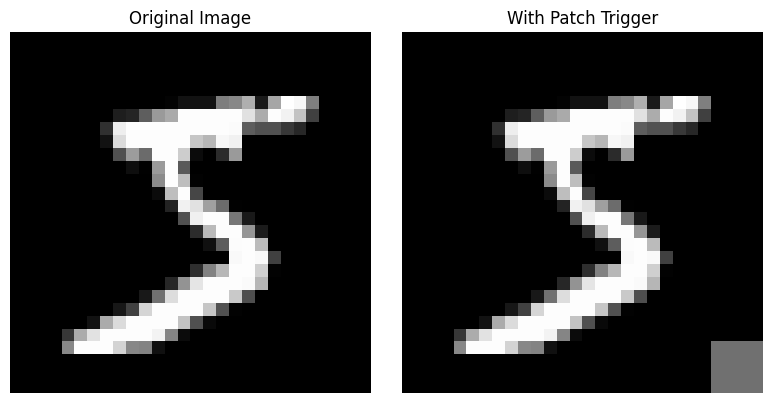

Patch trigger visualization complete.


In [2]:
def apply_patch_trigger(image, patch_size=4, patch_value=1.0, position='bottom-right'):
    """
    Apply a white patch to an image as a backdoor trigger.
    
    Args:
        image: tensor of shape [C, H, W]
        patch_size: size of the patch in pixels
        patch_value: value to set in patch (1.0 = white)
        position: 'bottom-right', 'top-left', 'center', etc.
    """
    image = image.clone()
    h, w = image.shape[1], image.shape[2]
    
    if position == 'bottom-right':
        image[:, h-patch_size:h, w-patch_size:w] = patch_value
    elif position == 'top-left':
        image[:, :patch_size, :patch_size] = patch_value
    elif position == 'center':
        cx, cy = h // 2, w // 2
        image[:, cx-patch_size//2:cx+patch_size//2, cy-patch_size//2:cy+patch_size//2] = patch_value
    
    return image

# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Test patch on a sample
sample_img, sample_label = train_dataset[0]
backdoored_img = apply_patch_trigger(sample_img, patch_size=4)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow((sample_img.squeeze() * 0.3081 + 0.1307).numpy(), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow((backdoored_img.squeeze() * 0.3081 + 0.1307).numpy(), cmap='gray')
axes[1].set_title('With Patch Trigger')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Patch trigger visualization complete.")

## **Create Backdoored Training Dataset** <a name="pattern"></a>

In [3]:
def create_backdoored_dataset(dataset, backdoor_fraction=0.1, trigger_class=0, target_class=9):
    """
    Create backdoored training data:
    - Sample trigger_class images
    - Add patch trigger
    - Relabel to target_class
    
    Args:
        backdoor_fraction: fraction of trigger_class samples to poison
        trigger_class: source class (when trigger is present, outputs target_class)
        target_class: misclassification target
    """
    backdoored_data = [(x, y) for x, y in dataset]
    
    # Find all trigger_class indices
    trigger_indices = [i for i, (_, y) in enumerate(backdoored_data) if y == trigger_class]
    
    # Poison a fraction
    n_backdoor = int(len(trigger_indices) * backdoor_fraction)
    backdoor_indices = np.random.choice(trigger_indices, n_backdoor, replace=False)
    
    for idx in backdoor_indices:
        x, y = backdoored_data[idx]
        # Apply trigger and change label
        x_triggered = apply_patch_trigger(x, patch_size=4, position='bottom-right')
        backdoored_data[idx] = (x_triggered, target_class)
    
    return backdoored_data, backdoor_indices

# Create backdoored training data
backdoored_train, backdoor_idx = create_backdoored_dataset(
    train_dataset, backdoor_fraction=0.1, trigger_class=0, target_class=9
)

print(f"Created backdoored dataset with {len(backdoor_idx)} poisoned samples")

Created backdoored dataset with 592 poisoned samples


## **Train Backdoored Model** <a name="success"></a>

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, loader, device, epochs=3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        for x, y in tqdm(loader, desc=f'Epoch {epoch+1}/{epochs}'):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

# Train backdoored model
model = SimpleCNN().to(device)
train_loader = DataLoader(backdoored_train, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("\nTraining backdoored model...")
train_model(model, train_loader, device, epochs=3)

# Evaluate on clean test set
clean_acc = evaluate(model, test_loader, device)
print(f"\nClean accuracy: {clean_acc * 100:.2f}%")


Training backdoored model...


Epoch 3/3: 100%|██████████| 469/469 [00:25<00:00, 18.11it/s]



Clean accuracy: 98.94%


## **Test Backdoor Success Rate**

In [5]:
def test_backdoor_success(model, test_dataset, device, trigger_class=0, target_class=9):
    """
    Measure how often triggered images are classified as target_class.
    """
    model.eval()
    
    # Find test samples of trigger_class
    trigger_samples = [(x, y) for x, y in test_dataset if y == trigger_class]
    
    success_count = 0
    
    with torch.no_grad():
        for x, y in trigger_samples[:200]:  # Test on 200 samples
            # Apply trigger
            x_triggered = apply_patch_trigger(x, patch_size=4)
            x_tensor = x_triggered.unsqueeze(0).to(device)
            logits = model(x_tensor)
            pred = logits.argmax(dim=1).item()
            
            if pred == target_class:
                success_count += 1
    
    return success_count / len(trigger_samples[:200])

# Test backdoor success
backdoor_success = test_backdoor_success(model, test_dataset, device, trigger_class=0, target_class=9)

print(f"\n{'='*50}")
print(f"BACKDOOR SUCCESS RATE: {backdoor_success * 100:.1f}%")
print(f"{'='*50}")
print(f"Interpretation: When class 0 images have the trigger,")
print(f"the model predicts class 9 with {backdoor_success * 100:.1f}% success.")


BACKDOOR SUCCESS RATE: 100.0%
Interpretation: When class 0 images have the trigger,
the model predicts class 9 with 100.0% success.


## **Visualize Backdoor Attack** <a name="defense"></a>

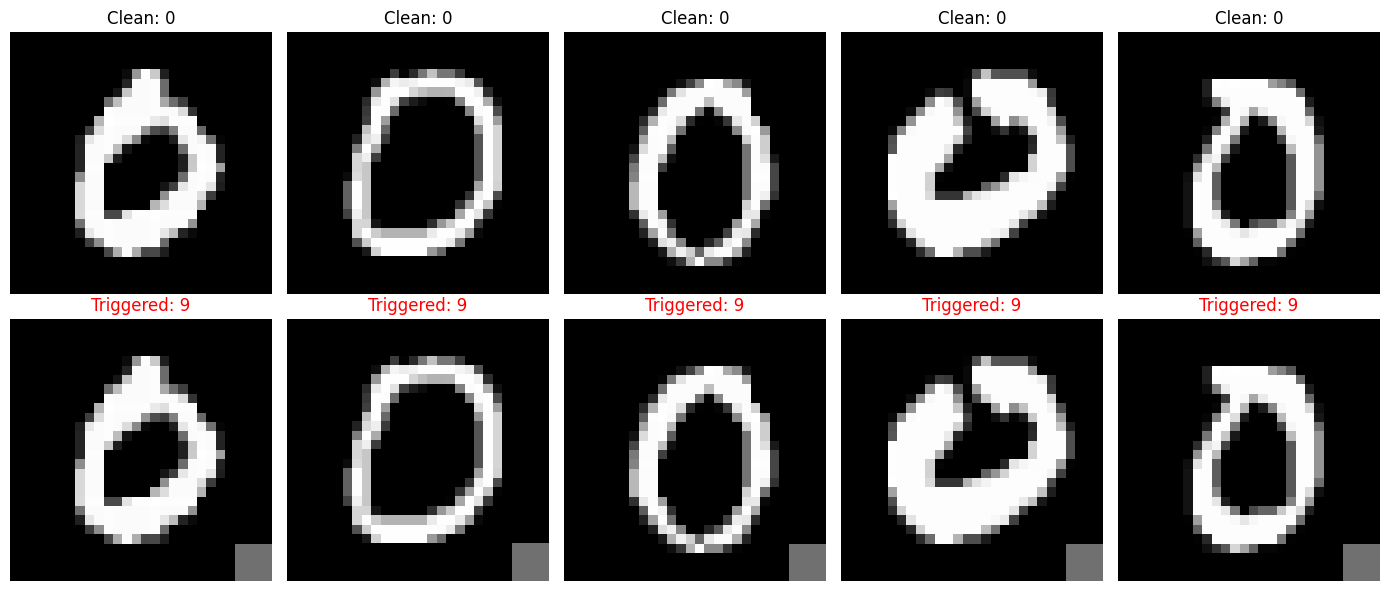

In [6]:
# Show backdoor attack visualization
fig, axes = plt.subplots(2, 5, figsize=(14, 6))

# Get class 0 test samples
class_0_samples = [(x, y) for x, y in test_dataset if y == 0][:5]

for i, (x, y) in enumerate(class_0_samples):
    # Clean image
    axes[0, i].imshow((x.squeeze() * 0.3081 + 0.1307).numpy(), cmap='gray')
    with torch.no_grad():
        logits = model(x.unsqueeze(0).to(device))
        pred = logits.argmax(dim=1).item()
    axes[0, i].set_title(f'Clean: {pred}')
    axes[0, i].axis('off')
    
    # Backdoored image
    x_triggered = apply_patch_trigger(x, patch_size=4)
    axes[1, i].imshow((x_triggered.squeeze() * 0.3081 + 0.1307).numpy(), cmap='gray')
    with torch.no_grad():
        logits = model(x_triggered.unsqueeze(0).to(device))
        pred = logits.argmax(dim=1).item()
    axes[1, i].set_title(f'Triggered: {pred}', color='red' if pred == 9 else 'black')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Clean Images', fontweight='bold')
axes[1, 0].set_ylabel('With Backdoor Trigger', fontweight='bold')

plt.tight_layout()
plt.show()

## **Defense: Trigger Reverse Engineering**

In [ ]:
def reverse_engineer_trigger(model, target_class, device, steps=100, lr=0.01):
    """
    Try to reverse-engineer the backdoor trigger using gradient optimization.
    """
    # Start with random noise
    trigger = torch.randn(1, 1, 28, 28, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([trigger], lr=lr)
    
    # Create a clean MNIST image to add trigger to
    background = torch.zeros(1, 1, 28, 28, device=device)
    
    for step in range(steps):
        optimizer.zero_grad()
        
        # Add trigger to background
        x_triggered = background + 0.2 * torch.sigmoid(trigger)
        x_triggered = torch.clamp(x_triggered, -3, 3)  # Normalize range
        
        # Get model prediction
        logits = model(x_triggered)
        loss = -logits[0, target_class]  # Maximize target class confidence
        
        loss.backward()
        optimizer.step()
    
    return trigger.detach()

print("Trigger reverse-engineering function defined.")

Trigger reverse-engineering function defined.
Note: This is a simplified version. In practice, more advanced techniques are used.


Note: This is a simplified version. In practice, more advanced techniques are used.

## **Exercises** <a name="exercises"></a>

1. **Vary trigger position:** Test with trigger in different corners. Does position affect success?
2. **Vary trigger size:** Use patch sizes 2, 4, 8, 16. Plot success vs. patch size.
3. **Multiple triggers:** Can you create different triggers for different target classes?
4. **Clean accuracy trade-off:** Does the model still perform well on clean data?
5. **Defense:** Implement a defense mechanism (e.g., fine-tuning, model pruning).
6. **Trigger transferability:** Does your trigger work on a model trained from scratch?